In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neural-style-transfer/content3.jpeg
/kaggle/input/neural-style-transfer/content1.jpg
/kaggle/input/neural-style-transfer/content6.jpg
/kaggle/input/neural-style-transfer/style2.jpg
/kaggle/input/neural-style-transfer/style1.jpg
/kaggle/input/neural-style-transfer/style6.jpg
/kaggle/input/neural-style-transfer/content5.jpg
/kaggle/input/neural-style-transfer/style4.jpeg
/kaggle/input/neural-style-transfer/content7.jpg
/kaggle/input/neural-style-transfer/style5.jpg
/kaggle/input/neural-style-transfer/content4.jpg
/kaggle/input/neural-style-transfer/style7.jpg
/kaggle/input/neural-style-transfer/content2.jpg
/kaggle/input/neural-style-transfer/style3.jpg
/kaggle/input/house-photo/house.jpg


# CHECK PATHS ABOVE BEFORE YOU SET THEM BELOW 

In [22]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np

# Determine device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define image size based on device
size = 512 if torch.cuda.is_available() else 256

# PREPROCESSING

In [23]:
# Normalization and denormalization transformations
model_normalization_mean = [0.485, 0.456, 0.406]
model_normalization_std = [0.229, 0.224, 0.225]

loader = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=model_normalization_mean, std=model_normalization_std)
])

unloader = transforms.Compose([
    transforms.Normalize(mean=[-m/s for m, s in zip(model_normalization_mean, model_normalization_std)], std=[1/s for s in model_normalization_std]),
    transforms.Lambda(lambda x: torch.clamp(x, 0, 1)), 
    transforms.ToPILImage()
])

def img_loader(img_name):
    image = Image.open(img_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def unloader_view(tensor):
    img = tensor.cpu().clone()
    img = img.squeeze(0)
    img = unloader(img)
    return img

# LOSS FUNCTIONS

In [24]:
def content_loss(input, target):
    target = target.detach()
    return F.mse_loss(input, target)

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

def style_loss(input, target):
    i_gram = gram_matrix(input)
    t_gram = gram_matrix(target).detach()
    return F.mse_loss(i_gram, t_gram)

# VGG MODEL WITH MODIFICATION

In [19]:
# Load VGG19 model
weights = models.VGG19_Weights.IMAGENET1K_V1
model = models.vgg19(weights=weights).features.to(device).eval()

def set_relu_inplace_false(model):
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            module.inplace = False

# Apply the function to the model (this is done because the layers cause problem to the content loss function)
set_relu_inplace_false(model)

def forward(x, layer_indices, model):
    output = []
    for i, layer in enumerate(model):
        x = layer(x)
        if i in layer_indices:
            output.append(x)
    return output

# RUN FUCNTION FOR NST 

In [19]:
def display_side_by_side(content_img, style_img, gen_img=None, stage='before'):
    content_img = np.array(unloader_view(content_img))
    style_img = np.array(unloader_view(style_img))
    
    if gen_img is not None:
        gen_img = np.array(unloader_view(gen_img))
    
    fig, ax = plt.subplots(1, 5 if gen_img is not None else 4, figsize=(15, 5))
    titles = ["CONTENT IMAGE", "", "STYLE IMAGE", "", "RESULT"] if stage == 'after' else ["CONTENT IMAGE", "", "STYLE IMAGE", "", ""]
    for i in range(4):
        ax[i].axis('off')
        if i % 2 == 0:
            ax[i].set_title(titles[i])
    ax[0].imshow(content_img)
    ax[0].axis('off')
    ax[1].text(0.5, 0.5, '+', fontsize=30, ha='center')
    ax[1].axis('off')
    ax[2].imshow(style_img)
    ax[2].axis('off')
    ax[3].text(0.5, 0.5, '=' if stage == 'after' else '?', fontsize=30, ha='center')
    ax[3].axis('off')
    
    if gen_img is not None:
        ax[4].imshow(gen_img)
        ax[4].axis('off')
    
    plt.show()

def run_style_transfer(content_img_path, style_img_path, epochs=1000, style_weight=1e6, content_weight=1, lr=0.1):
    con_img = img_loader(content_img_path)
    sty_img = img_loader(style_img_path)
    gen_img = con_img.clone().requires_grad_(True)
    
    print("Initial Images")
    
    display_side_by_side(con_img, sty_img, stage='before')
    
    print("Neural Style Transfer Ongoing....")
    optimizer = torch.optim.Adam([gen_img], lr=lr)

    content_layers = [22]
    style_layers = [1, 6, 11, 20, 29]
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        style_features = forward(sty_img, style_layers, model)
        content_features = forward(con_img, content_layers, model)
        gen_style_features = forward(gen_img, style_layers, model)
        gen_content_features = forward(gen_img, content_layers, model)
        
        style_losses = [style_loss(gs, s) for gs, s in zip(gen_style_features, style_features)]
        content_losses = [content_loss(gc, c) for gc, c in zip(gen_content_features, content_features)]
        
        total_loss = style_weight * sum(style_losses) + content_weight * sum(content_losses)
        total_loss.backward()
        
        optimizer.step()
    
    print("Final Images")
    display_side_by_side(con_img, sty_img, gen_img, stage='after')
    
    return gen_img

# USAGE 

Initial Images


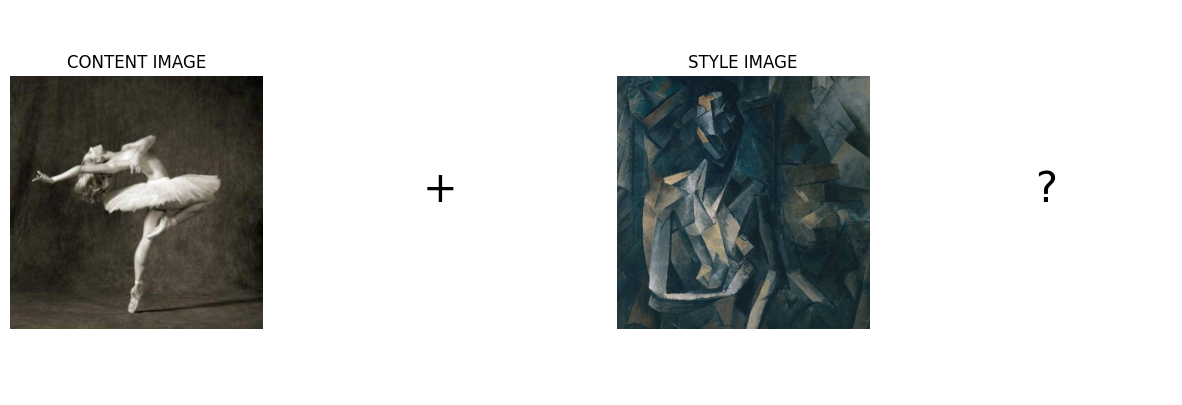

Neural Style Transfer Ongoing....
Final Images


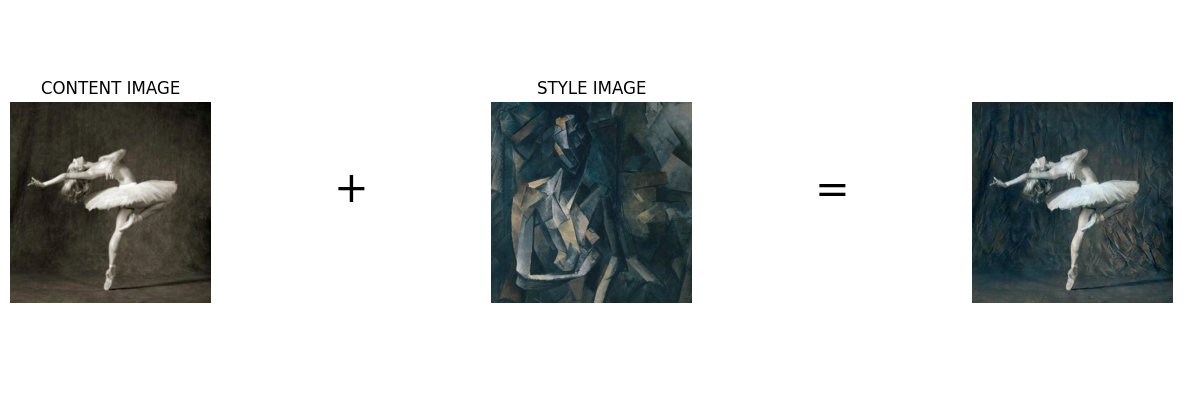

RESULTANT IMAGE
SAVING AS  content3 + style4 .png


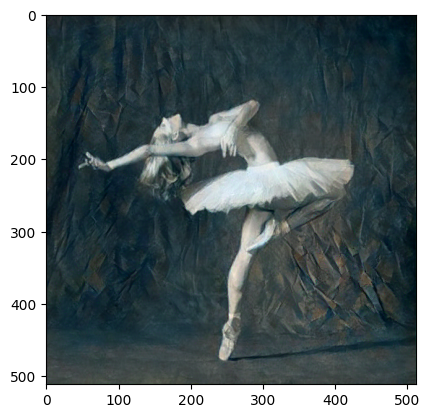

In [19]:
# Example usage
content_img_path = '/kaggle/input/neural-style-transfer/content6.jpg'  # Set your Path to the content image
style_img_path = '/kaggle/input/neural-style-transfer/style7.jpg'    # Set your Path to the style image

result_img = run_style_transfer(content_img_path, style_img_path, epochs=1000, style_weight=1e6, content_weight=1, lr=0.01)

# Save the generated image
content_img_name = content_img_path.split('/')[-1].split('.')[0]
style_img_name = style_img_path.split('/')[-1].split('.')[0]
result_img = unloader(result_img.clone().cpu().squeeze(0))
print("RESULTANT IMAGE")
plt.imshow(result_img)
print("SAVING AS ",content_img_name,"+",style_img_name,".png")
result_img.save(f'{content_img_name}+{style_img_name}.png')

# Hyper Parameter tuning (code for reference)

In [ ]:
# import itertools
# import torch
# from torch.optim import Adam

# # Define any required functions such as img_loader, forward, style_loss, content_loss here
# # Assume these are already defined.

# def evaluate_style_transfer(content_img_path, style_img_path, style_weight, content_weight, epochs, lr):
#     con_img = img_loader(content_img_path)
#     sty_img = img_loader(style_img_path)
#     gen_img = con_img.clone().requires_grad_(True)
    
#     optimizer = Adam([gen_img], lr=lr)
#     content_layers = [22]
#     style_layers = [1, 6, 11, 20, 29]
    
#     for epoch in range(epochs):
#         optimizer.zero_grad()
        
#         style_features = forward(sty_img, style_layers, model)
#         content_features = forward(con_img, content_layers, model)
#         gen_style_features = forward(gen_img, style_layers, model)
#         gen_content_features = forward(gen_img, content_layers, model)
        
#         style_losses = [style_loss(gs, s) for gs, s in zip(gen_style_features, style_features)]
#         content_losses = [content_loss(gc, c) for gc, c in zip(gen_content_features, content_features)]
        
#         total_loss = style_weight * sum(style_losses) + content_weight * sum(content_losses)
#         total_loss.backward()
        
#         optimizer.step()
        
#        
    
#     # Calculate final style and content losses
#     final_gen_style_features = forward(gen_img, style_layers, model)
#     final_gen_content_features = forward(gen_img, content_layers, model)
    
#     final_style_loss = sum([style_loss(gs, s) for gs, s in zip(final_gen_style_features, style_features)])
#     final_content_loss = sum([content_loss(gc, c) for gc, c in zip(final_gen_content_features, content_features)])
    
#     return final_style_loss.item(), final_content_loss.item()

# # Define the hyperparameter grid
# style_weights = [10, 100, 1000, 10000, 100000, 1000000]
# content_weights = [1, 10, 100]
# epochs_list = [500, 750, 1000]
# learning_rates = [0.01, 0.1, 1, 3, 5, 7]

# # Store results
# results = []
# content_img_path = '/kaggle/input/content3.jpeg'
# style_img_path = '/kaggle/input/style4.jpeg'

# # Initialize best result variables
# best_style_loss = float('inf')
# best_content_loss = float('inf')
# best_result = None

# # Loop through all combinations
# for style_weight, content_weight, epochs, lr in itertools.product(style_weights, content_weights, epochs_list, learning_rates):
#     final_style_loss, final_content_loss = evaluate_style_transfer(
#         content_img_path, style_img_path, style_weight, content_weight, epochs, lr
#     )
#     result = {
#         'style_weight': style_weight,
#         'content_weight': content_weight,
#         'epochs': epochs,
#         'learning_rate': lr,
#         'final_style_loss': final_style_loss,
#         'final_content_loss': final_content_loss
#     }
#     results.append(result)
    
#     # Check if the current result is the best so far
#     if (final_style_loss < best_style_loss) or (final_style_loss == best_style_loss and final_content_loss < best_content_loss):
#         best_style_loss = final_style_loss
#         best_content_loss = final_content_loss
#         best_result = result
    
#     # Print the best result after each iteration
#     print(f"Current Best Hyperparameters: {best_result}")

# # Sort results by final_style_loss and final_content_loss
# sorted_results = sorted(results, key=lambda x: (x['final_style_loss'], x['final_content_loss']))

# # Print the best hyperparameter combination
# best_result = sorted_results[0]
# print(f"Best Hyperparameters: {best_result}")


In [ ]:
# import torch
# import torch.nn.functional as F
# import torch.nn as nn
# from PIL import Image
# from torchvision import models, transforms
# import matplotlib.pyplot as plt

# # Determine device
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # Define image size based on device
# size = 512 if torch.cuda.is_available() else 128

# # Normalization and denormalization transformations
# model_normalization_mean = [0.485, 0.456, 0.406]
# model_normalization_std = [0.229, 0.224, 0.225]

# loader = transforms.Compose([
#     transforms.Resize(size),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=model_normalization_mean, std=model_normalization_std)
# ])

# unloader = transforms.Compose([
#     transforms.Normalize(mean=[-m/s for m, s in zip(model_normalization_mean, model_normalization_std)], std=[1/s for s in model_normalization_std]),
#     transforms.Lambda(lambda x: torch.clamp(x, 0, 1)),  
#     transforms.ToPILImage()
# ])

# def img_loader(img_name):
#     image = Image.open(img_name)
#     image = loader(image).unsqueeze(0)
#     return image.to(device, torch.float)

# def unloader_view(tensor):
#     img = tensor.cpu().clone()
#     img = img.squeeze(0)
#     img = unloader(img)
#     plt.imshow(img)
#     plt.pause(0.001)

# def content_loss(input, target):
#     target = target.detach()
#     return F.mse_loss(input, target)

# def gram_matrix(input):
#     a, b, c, d = input.size()
#     features = input.view(a * b, c * d)
#     G = torch.mm(features, features.t())
#     return G.div(a * b * c * d)

# def style_loss(input, target):
#     i_gram = gram_matrix(input)
#     t_gram = gram_matrix(target).detach()
#     return F.mse_loss(i_gram, t_gram)

# # Load VGG19 model
# weights = models.VGG19_Weights.IMAGENET1K_V1
# model = models.vgg19(weights=weights).features.to(device).eval()

# def set_relu_inplace_false(model):
#     for module in model.modules():
#         if isinstance(module, nn.ReLU):
#             module.inplace = False

# # Apply the function to the model( this is done because the layers cause problem to the content loss function)
# set_relu_inplace_false(model)

# def forward(x, layer_indices, model):
#     output = []
#     for i, layer in enumerate(model):
#         x = layer(x)
#         if i in layer_indices:
#             output.append(x)
#     return output

# def run_style_transfer(content_img_path, style_img_path, epochs=1000, style_weight=1e6, content_weight=1, lr=0.1):
#     con_img = img_loader(content_img_path)
#     sty_img = img_loader(style_img_path)
#     gen_img = con_img.clone().requires_grad_(True)
#     print("CONTENT IMG")
#     unloader_view(con_img)
#     print("STYLE IMG")
#     unloader_view(sty_img)
#     print("GEN_INIT IMG")
#     unloader_view(gen_img)
#     optimizer = torch.optim.Adam([gen_img], lr=lr)

#     content_layers = [22]
#     style_layers = [1, 6, 11, 20, 29]
    
#     for epoch in range(epochs):
#         optimizer.zero_grad()
#         style_features = forward(sty_img, style_layers, model)
#         content_features = forward(con_img, content_layers, model)
#         gen_style_features = forward(gen_img, style_layers, model)
#         gen_content_features = forward(gen_img, content_layers, model)
        
#         style_losses = [style_loss(gs, s) for gs, s in zip(gen_style_features, style_features)]
#         content_losses = [content_loss(gc, c) for gc, c in zip(gen_content_features, content_features)]
        
#         total_loss = style_weight * sum(style_losses) + content_weight * sum(content_losses)
#         total_loss.backward()
        
#         optimizer.step()
    
#     return gen_img

# # Example usage
# content_img_path = '/kaggle/input/neural-style-transfer/content3.jpeg'  # Path to the content image
# style_img_path = '/kaggle/input/neural-style-transfer/style4.jpeg'    # Path to the style image

# result_img = run_style_transfer(content_img_path, style_img_path, epochs=1000, style_weight=1e6, content_weight=1, lr=0.01)
# unloader_view(result_img)
